# BRD4 Inhibitors Conformers

### Libraries

In [1]:
import sys

sys.path.append("..")

In [2]:
import open3d as o3d
import numpy as np
import seaborn as sns
import pandas as pd

import re, os
from io import StringIO

import py3Dmol

from rdkit import Chem
from rdkit.Chem import AllChem

import ipywidgets as widgets
from ipywidgets import fixed
from IPython.display import HTML

from spyrmsd import molecule, rmsd

from open3d.web_visualizer import draw

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2021-07-22 10:39:29,602 - __init__ - Enabling RDKit 2021.03.3 jupyter extensions


[Open3D INFO] Resetting default logger to print to terminal.


In [3]:
from score_pcd import fit_and_score

## BRD4 Inhibitors

### Load Molecules

Load all BRD4 inhibitors as SDF and PCD files:

In [4]:
path = "ligands/BRD4"
files = [os.path.join(path, f) for f in os.listdir(path) if os.path.splitext(f)[-1] == ".sdf" and os.path.splitext(f)[0][-4:] == "tran"]

# Sort BRD4 ligand files by number
r = re.compile("\d{1,2}")
files.sort(key=lambda f: int(r.search(os.path.basename(f)).group()))

mols = []
pcds = []
for f in files:
    s = Chem.SDMolSupplier(f)
    mol = next(s)
    mols.append(mol)

    pcd = o3d.io.read_point_cloud(f.replace(".sdf", ".pcd"))
    pcds.append(pcd)

print(mols)

[<rdkit.Chem.rdchem.Mol object at 0x7f7da2401f80>, <rdkit.Chem.rdchem.Mol object at 0x7f7da2401f30>, <rdkit.Chem.rdchem.Mol object at 0x7f7da24017b0>, <rdkit.Chem.rdchem.Mol object at 0x7f7da2402030>, <rdkit.Chem.rdchem.Mol object at 0x7f7da2402080>, <rdkit.Chem.rdchem.Mol object at 0x7f7da24020d0>, <rdkit.Chem.rdchem.Mol object at 0x7f7da2402120>, <rdkit.Chem.rdchem.Mol object at 0x7f7da2402170>, <rdkit.Chem.rdchem.Mol object at 0x7f7da24021c0>, <rdkit.Chem.rdchem.Mol object at 0x7f7da2402210>]


In [5]:
def update(index=0):
    sio = StringIO()
    with Chem.SDWriter(sio) as w:
        w.write(mols[index])

    view = py3Dmol.view(data=sio.getvalue(), style={'stick':{'colorscheme':'greyCarbon'}})
    view.zoomTo()
    view.show()
    
_ = widgets.interact(update, index=widgets.IntSlider(min=0, max=len(mols)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='index', max=9), Output()), _dom_classes=('widget-interac…

### Generate Conformers

In [6]:
# Create conformers for a given molecule
molID = 9
cmol = mols[molID]
cmol = Chem.AddHs(cmol)
cids = AllChem.EmbedMultipleConfs(cmol, numConfs=10)

# https://rdkit.blogspot.com/2016/07/using-ipywidgets-and-py3dmol-to-browse.html

def drawit(m, p, confId=-1):
    mb = Chem.MolToMolBlock(m, confId=confId)
    p.removeAllModels()
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    #p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()

p = py3Dmol.view(width=400,height=400)
_ = widgets.interact(drawit, m=fixed(cmol), p=fixed(p), confId=(0, cmol.GetNumConformers()-1))

interactive(children=(IntSlider(value=0, description='confId', max=9), Output()), _dom_classes=('widget-intera…

In [7]:
def drawit_nointeractive(m,p ,confId=-1):
        mb = Chem.MolToMolBlock(m,confId=confId)
        p.addModel(mb,'sdf')
        p.setStyle({'stick':{}})
        #p.setBackgroundColor('0xeeeeee')
        p.zoomTo()
    
p = py3Dmol.view(width=400,height=400)
for confId in range(10):
    drawit_nointeractive(cmol, p, confId)
p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The generated conformers can now be saved in a SDF file:

In [8]:
# Save conformers to separate files
for i in range(cmol.GetNumConformers()):
    with Chem.SDWriter(os.path.join(path, f"conf_{i}.sdf")) as w:
        w.write(cmol, confId=i)
        
n_conf_minus_one = cmol.GetNumConformers() - 1

Given that `molgrid` installed from PyPI is incompatible with `openbabel`, we need to run `molgrid_to_pcd` within a Singularity container in order to generate PCD files:

In [9]:
!ls ligands/BRD4 | grep conf

conf_0.pcd
conf_0.sdf
conf_1.pcd
conf_1.sdf
conf_2.pcd
conf_2.sdf
conf_3.pcd
conf_3.sdf
conf_4.pcd
conf_4.sdf
conf_5.pcd
conf_5.sdf
conf_6.pcd
conf_6.sdf
conf_7.pcd
conf_7.sdf
conf_8.pcd
conf_8.sdf
conf_9.pcd
conf_9.sdf


In [10]:
%%bash -s "$path" "$n_conf_minus_one"

# Python variable path passed to bash
# Can be accessed with $1

# Python variable n_conf_minus_one passed to bash
# Can be accessed with $2

# Unfortunately molgrid does not work well with pybel
# molgrid_to_pcd needs to run within a Singularity container
# (RDKit and molgrid compiled from source!)
# See https://github.com/gnina/libmolgrid/issues/62

for CONF in $(seq 0 $2)
do
    singularity run --nv --app python ../development/densitymatch.sif \
        ../molgrid_to_pcd.py ${PWD}/${1}/conf_${CONF}.sdf -o ${PWD}/${1}/conf_${CONF}.pcd \
            --ligmap ${PWD}/../files/ligmap
done

In [11]:
!ls ligands/BRD4 | grep "conf.*\.pcd"

conf_0.pcd
conf_1.pcd
conf_2.pcd
conf_3.pcd
conf_4.pcd
conf_5.pcd
conf_6.pcd
conf_7.pcd
conf_8.pcd
conf_9.pcd


We can finally load the PCD files for the conformers:

In [12]:
cpcds = []
cmols = []

files = [os.path.join(path, f"conf_{i}.pcd") for i in range(cmol.GetNumConformers())]

print(files)

for f in files:
    pcd = o3d.io.read_point_cloud(f)
    cpcds.append(pcd)

    s = Chem.SDMolSupplier(f.replace(".pcd", ".sdf"))
    mol = next(s)
    cmols.append(mol)

print(cpcds)

['ligands/BRD4/conf_0.pcd', 'ligands/BRD4/conf_1.pcd', 'ligands/BRD4/conf_2.pcd', 'ligands/BRD4/conf_3.pcd', 'ligands/BRD4/conf_4.pcd', 'ligands/BRD4/conf_5.pcd', 'ligands/BRD4/conf_6.pcd', 'ligands/BRD4/conf_7.pcd', 'ligands/BRD4/conf_8.pcd', 'ligands/BRD4/conf_9.pcd']
[PointCloud with 990 points., PointCloud with 1003 points., PointCloud with 984 points., PointCloud with 997 points., PointCloud with 988 points., PointCloud with 1015 points., PointCloud with 992 points., PointCloud with 958 points., PointCloud with 1005 points., PointCloud with 1014 points.]


## Similarity Between Conformers

In [13]:
# Score is not symmetric because RANSAC is currently not deterministic
# See https://github.com/intel-isl/Open3D/issues/1263
# Would the score be symmetric if this was not the case?
n = len(cpcds)
Sfitness = np.zeros((n,n))

for i, pcd1 in enumerate(cpcds):
    for j, pcd2 in enumerate(cpcds):
        gfit, cfit, _ = fit_and_score((pcd1, pcd2), voxel_size=0.5, threshold=0.5)
        Sfitness[i, j] = cfit.fitness

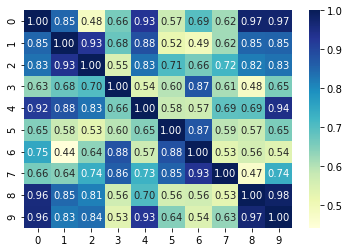

In [14]:
ax = sns.heatmap(Sfitness, cmap="YlGnBu", annot=True, fmt=".2f")

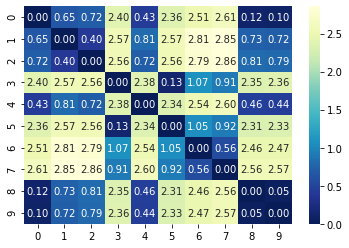

In [15]:
# Compute RMSD
scmols = [molecule.Molecule.from_rdkit(mol) for mol in cmols]

n = len(scmols)
RMSDs = np.zeros((n,n))

for i, mol1 in enumerate(scmols):
    for j, mol2 in enumerate(scmols):
        RMSDs[i,j] = rmsd.rmsdwrapper(mol1, mol2, minimize=True)[0]

ax = sns.heatmap(RMSDs, cmap="YlGnBu_r", annot=True, fmt=".2f")


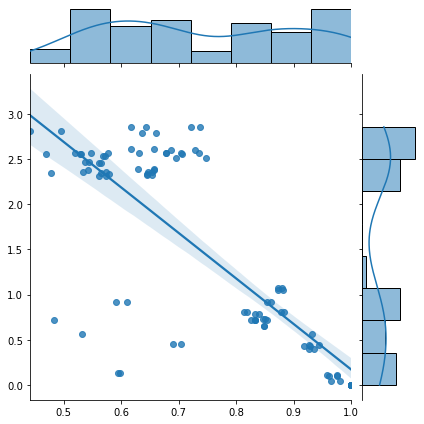

In [16]:
g = sns.jointplot(x=Sfitness.reshape(-1), y=RMSDs.reshape(-1),kind="reg")

In [17]:
from scipy.stats import pearsonr

pearsonr(Sfitness.reshape(-1), RMSDs.reshape(-1))

(-0.7923460199933783, 9.356416176975265e-23)

In [18]:
def align_conf_and_show(cidx, idx):
    """
    Align given conformer with original BRD4 ligand.
    """
    pcd1, pcd2 = cpcds[cidx], pcds[idx]
    mol1, mol2 = cmols[cidx], mols[idx]
    
    fit, cfit, tran = fit_and_score((pcd1, pcd2), voxel_size=0.5, threshold=0.5)

    print(cfit.fitness)

    # Get coordinates to transform
    coords = mol1.GetConformer(0).GetPositions()

    # Augment coordinates with ones
    coords_aug = np.ones((coords.shape[0], 4))
    coords_aug[:,:3] = coords

    # Compute new (transformed) coordinates
    coords_new = np.matmul(tran, coords_aug.T)[:3,:].T

    # Add new coordinates as conformer
    n_atoms = mol1.GetNumAtoms()
    conf = Chem.Conformer(n_atoms)
    for i in range(n_atoms):
        conf.SetAtomPosition(i, coords_new[i,:])

    _ = mol1.AddConformer(conf, assignId=True)

    # Create view
    p = py3Dmol.view()
    p.addModel(Chem.MolToMolBlock(mol1, confId=0),'sdf')
    p.addModel(Chem.MolToMolBlock(mol1, confId=1),'sdf')
    p.addModel(Chem.MolToMolBlock(mol2, confId=0),'sdf')

    p.setStyle({"model": 0}, {'stick':{'colorscheme':'lightgreyCarbon'}})
    p.setStyle({"model": 1}, {'stick':{'colorscheme':'redCarbon'}})
    p.setStyle({"model": 2}, {'stick':{'colorscheme':'greyCarbon'}})

    p.zoomTo()

    return p

In [19]:
def draw_align(confId, idx):
    p = align_conf_and_show(confId, idx)


    return p.show()

_ = widgets.interact(draw_align, confId=(0, cmol.GetNumConformers()-1), idx=(0, len(mols) - 1))

interactive(children=(IntSlider(value=4, description='confId', max=9), IntSlider(value=4, description='idx', m…